In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

# 불균형데이터의 예측 성능

## 사례 1. ROC < PR 곡선 (불균형자료)

# Data Obtain

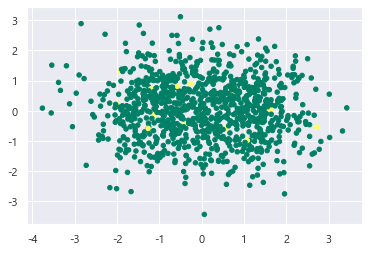

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01],
                          random_state=1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='summer')

In [5]:
X.shape, y.shape

((1000, 20), (1000,))

In [6]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 985, 1: 15}

In [7]:
pd.Series(y).value_counts()

0    985
1     15
dtype: int64

## 반반씩 나눠 봄 - stratify

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

In [9]:
# summarize dataset
print(f'Dataset: Class0={(y==0).sum()}, Class1={(y==1).sum()}')
print(f'Train  : Class0={(y_train==0).sum()}, Class1={(y_train==1).sum()}')
print(f'Test   : Class0={(y_test==0).sum()}, Class1={(y_test==1).sum()}')

Dataset: Class0=985, Class1=15
Train  : Class0=492, Class1=8
Test   : Class0=493, Class1=7


In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

LogisticRegression()

In [11]:
# import warnings
# warnings.filterwarnings('ignore')

In [12]:
from sklearn.metrics import classification_report
y_pred   = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)

target_names = ['Negative(0)', 'Positive(1)']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Negative(0)       0.99      1.00      0.99       493
 Positive(1)       0.00      0.00      0.00         7

    accuracy                           0.99       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.99      0.98       500



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

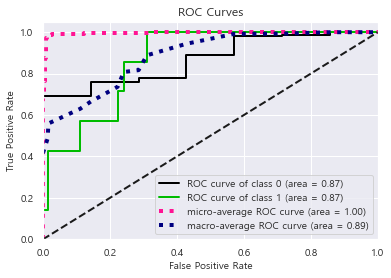

In [13]:
import scikitplot as skplt 
skplt.metrics.plot_roc(y_test, y_probas)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

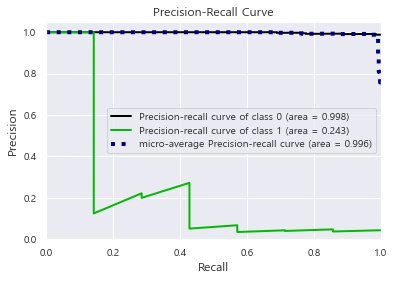

In [14]:
skplt.metrics.plot_precision_recall(y_test, y_probas)

### ROC와 PR curve는 다른 이야기를 하고 있으며 불균형데이터의 예측 성능지표는 AUROC보다는 PR그래프가 우수하다.
#### PR 그래프는 소수 범주 자료(양성, 1%)에 집중하는 반면 ROC curve는 음성과 양성 범주 자료를 모두 고려하기 때문이다.

#### 사이킷런 내부 모델의 의사결정임계값은 '0.5'로 예측 모델의 결과인 500개는 모두 음성으로 판정한 것을 확인할 수있으며 양성판정 비율은 모두 0.22 이하인 것으로 나타남

In [15]:
np.sort(y_probas[:, 1].round(2))

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

## predict_probas에 의한 값중 가장 큰 값이 0.22 --> 0.5를 threshold로 하면 모두 0으로 예측됨

In [16]:
pd.Series(y_pred).value_counts()

0    500
dtype: int64

## y_probas 분포
#### 한쪽에 몰려 있음

0.2238808172791911

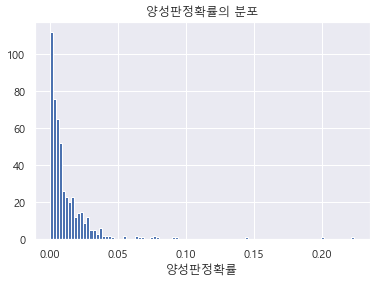

In [17]:
y_scores = y_probas[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포')
plt.xlabel('양성판정확률')
np.max(y_scores)

In [18]:
data = pd.DataFrame(y_scores, columns=['y_predict'])
data

,y_predict
0,0.042028
1,0.001389
2,0.006842
3,0.028677
4,0.000467
...,...
495,0.011425
496,0.036711
497,0.002462
498,0.014941


## Calibrate Probabilities

In [19]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=3)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=3)

In [20]:
calibrated_clf.predict_proba(X_train)[:5, :]

array([[0.98019388, 0.01980612],
       [0.98108605, 0.01891395],
       [0.98378488, 0.01621512],
       [0.98355421, 0.01644579],
       [0.98057176, 0.01942824]])

### 골고루 균형있게 변화

Text(0.5, 0, '양성판정확률')

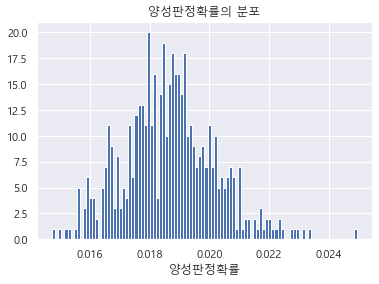

In [21]:
yhat = calibrated_clf.predict_proba(X_test)
model_probs = yhat[:, 1]
pd.DataFrame(model_probs).hist(bins=100)
plt.title('양성판정확률의 분포')
plt.xlabel('양성판정확률')

array([[<AxesSubplot:title={'center':'y_predict'}>,
        <AxesSubplot:title={'center':'y_predict_calibrated'}>]],
      dtype=object)

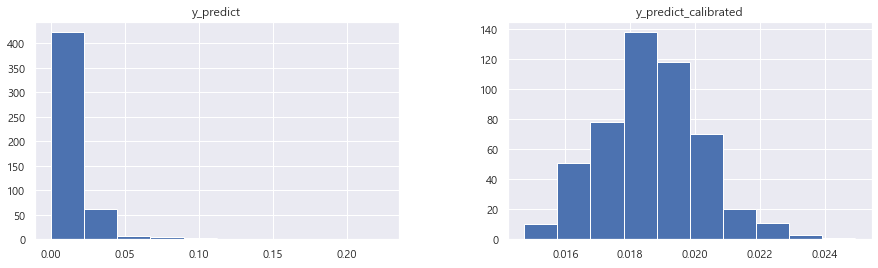

In [22]:
data['y_predict_calibrated'] = yhat[:, 1]
data.hist(figsize=(15,4))

In [23]:
data.head()

,y_predict,y_predict_calibrated
0,0.042028,0.017638
1,0.001389,0.017361
2,0.006842,0.017920
3,0.028677,0.017331
4,0.000467,0.020988


In [24]:
data.reset_index().rename(columns={'index':'idx'})

,idx,y_predict,y_predict_calibrated
0,0,0.042028,0.017638
1,1,0.001389,0.017361
2,2,0.006842,0.017920
3,3,0.028677,0.017331
4,4,0.000467,0.020988
...,...,...,...
495,495,0.011425,0.015004
496,496,0.036711,0.016498
497,497,0.002462,0.018764
498,498,0.014941,0.016098


<AxesSubplot:xlabel='index', ylabel='y_predict_calibrated'>

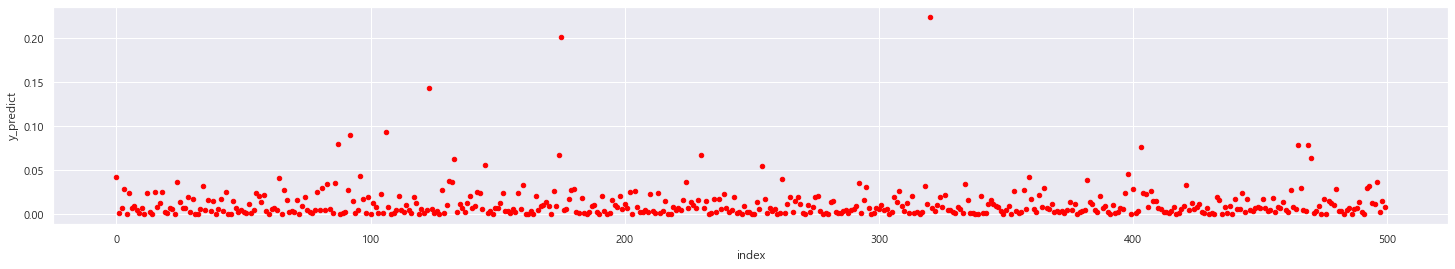

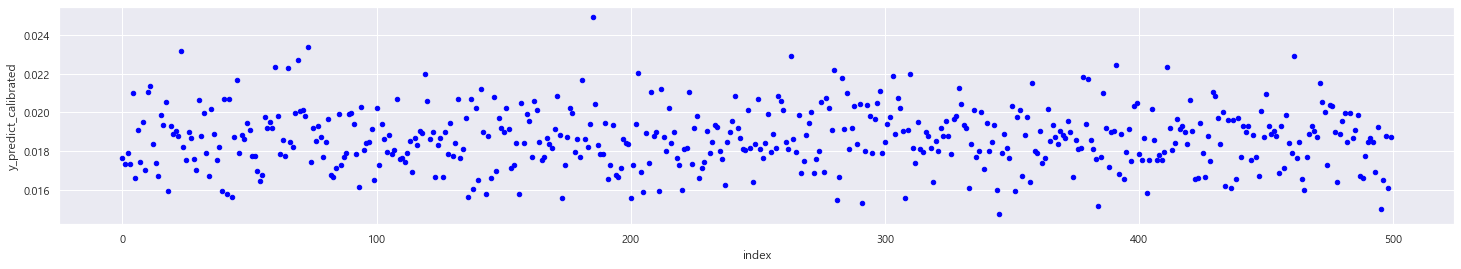

In [25]:
import warnings
warnings.filterwarnings(action='ignore') 
data.reset_index().plot.scatter(x='index', y='y_predict',            c='red', figsize=(25,4))
data.reset_index().plot.scatter(x='index', y='y_predict_calibrated', c='blue', figsize=(25,4))

https://scikit-learn.org/stable/modules/calibration.html#calibration

## 사례 2. PR > ROC (불균형자료)

In [26]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1024)
y_predict = model.fit(X_train, y_train).predict(X_test)
y_scores  = model.fit(X_train, y_train).decision_function(X_test)

(array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

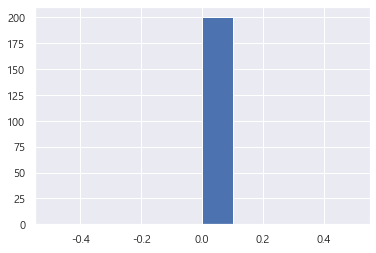

In [27]:
plt.hist(y_predict)

(array([ 5., 18., 48., 42., 30., 24., 15., 10.,  6.,  2.]),
 array([-1.1998489 , -1.16727311, -1.13469733, -1.10212155, -1.06954577,
        -1.03696999, -1.00439421, -0.97181843, -0.93924265, -0.90666687,
        -0.87409109]),
 <BarContainer object of 10 artists>)

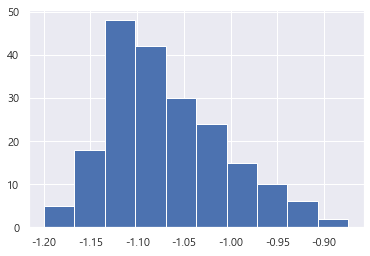

In [28]:
plt.hist(y_scores)

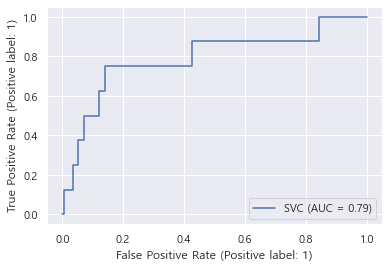

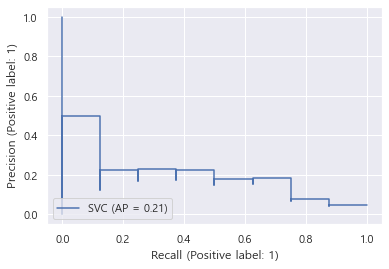

In [29]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
svc_disp = plot_roc_curve(model, X_test, y_test); plt.show()
svc_disp = plot_precision_recall_curve(model, X_test, y_test)

In [30]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       0.00      0.00      0.00         8

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.92      0.96      0.94       200



# Imbalanced_classification_with_python(by Jason brown)
### ROC Curve의 최적 Threshold  찾기

In [31]:
# https://machinelearningmastery.com/imbalanced-classification-with-python/

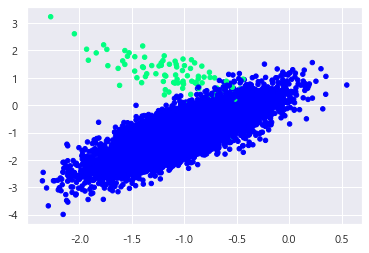

In [32]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='winter')

### LogisticRegression으로 학습
### roc_curve

In [33]:
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

y_pred   = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_probas)

#### y_probas 분포

(array([4.933e+03, 2.100e+01, 1.000e+01, 3.000e+00, 6.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 4.000e+00, 1.400e+01]),
 array([7.26905980e-07, 1.00000489e-01, 2.00000251e-01, 3.00000013e-01,
        3.99999775e-01, 4.99999537e-01, 5.99999299e-01, 6.99999061e-01,
        7.99998823e-01, 8.99998585e-01, 9.99998347e-01]),
 <BarContainer object of 10 artists>)

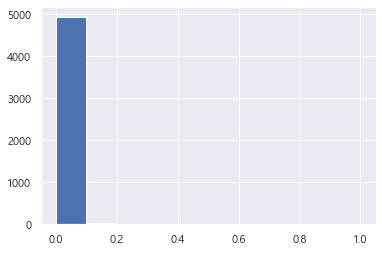

In [34]:
plt.hist(y_probas)

### Geometric Mean이 최대가 되는 점 찾기

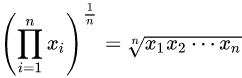

In [35]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print(f'Best Threshold={thresholds[ix]}, G-mean={gmeans[ix]}')

Best Threshold=0.016152851152469214, G-mean=0.9334372236551586


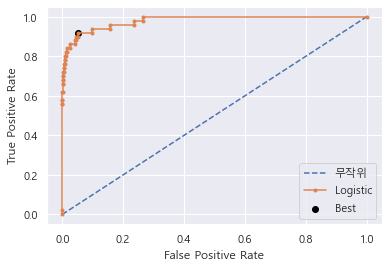

In [36]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='무작위')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

## Youden’s J statistic을 이용하면 좀더 쉽게 계산
### J = Sensitivity + Specificity − 1 = Sensitivity + (1 − FalsePositiveRate) − 1 =  TruePositiveRate − FalsePositiveRate

In [37]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold={best_thresh}')

Best Threshold=0.016152851152469214


### Precision-Recall Curve의 최적 Threshold  찾기
#### ROC Curve와 달리 precision-recall curve는 관심있는 클래스의 performance에 중점을 둠

In [38]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probas)

#### f-score가 가장 커지는 점 찾기

In [39]:
# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-measure={fscore[ix]:.5f}')

Best Threshold=0.256, F-measure=0.75556


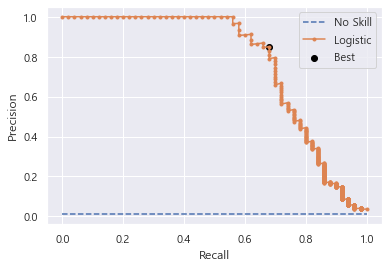

In [40]:
# plot the Precision-Recall curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

### Optimal Threshold Tuning

#### threshold 보다 크면 1값을 갖도록 하는 함수

In [41]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

#### y_probas를 구함

In [42]:
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
# predict probabilities
y_probas = model.predict_proba(X_test)[:,1]

#### 여러 threshold 정의

In [43]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)

#### f1_score를 계산하는 함수를 가지고 threshold에 따라 f1_score 값을 계산

In [44]:
# evaluate each threshold
from sklearn.metrics import f1_score
f_scores = [f1_score(y_test, to_labels(y_probas, t)) for t in thresholds]

# get best threshold
ix = np.argmax(f_scores)
print(f'Threshold={thresholds[ix]:.3f}, F-measure={f_scores[ix]:.5f}')

Threshold=0.251, F-measure=0.75556


## 성과지표 요약

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probas)
display(pd.DataFrame(np.vstack([precision, recall]), index=['정밀도', '재현율']).round(2))
display(pd.DataFrame(thresholds,columns=['분류임계값']).T.round(3))

,0,1,2,3,4,5,6,7,8,9,...,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363
정밀도,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.0
재현율,1.00,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,...,0.18,0.16,0.14,0.12,0.1,0.08,0.06,0.04,0.02,0.0


,0,1,2,3,4,5,6,7,8,9,...,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362
분류임계값,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.965,0.977,0.99,0.992,0.997,0.998,0.998,0.999,1.0,1.0


### 분류임계값에 따라 Positive 판정율 내리는 비율
- 재현율과 정밀도가 교차하는 지점이 오른쪽에 있을 수록 better estimator
- f1_score가 높은 threshold가 좋은 임계값?

In [46]:
scores = [np.sum(to_labels(y_probas, t))/len(y_probas) for t in thresholds]

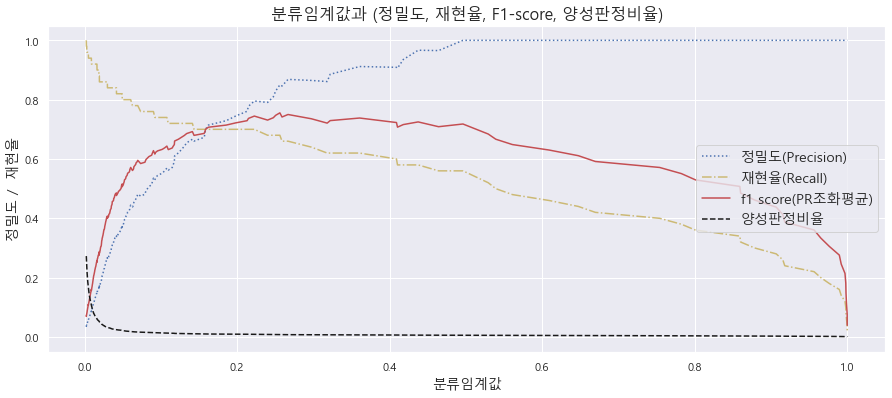

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.rcParams["figure.figsize"] = (15,6)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b:', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls[:-1], 'y-.', label='재현율(Recall)') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, scores, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(precision, recall, thresholds)

## 다양한 metrics로 Tuning

In [48]:
from sklearn.model_selection import RandomizedSearchCV

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')

In [49]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

In [50]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}

In [51]:
randomized = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring = 'accuracy', random_state=1)
y_predict = randomized.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
print(randomized.best_estimator_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       1.00      0.56      0.72        50

    accuracy                           1.00      5000
   macro avg       1.00      0.78      0.86      5000
weighted avg       1.00      1.00      0.99      5000

LogisticRegression(C=206.913808111479)


In [52]:
randomized = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring = 'recall', random_state=1)
y_predict = randomized.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
print(randomized.best_estimator_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       1.00      0.56      0.72        50

    accuracy                           1.00      5000
   macro avg       1.00      0.78      0.86      5000
weighted avg       1.00      1.00      0.99      5000

LogisticRegression(C=206.913808111479)


In [53]:
randomized = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring = 'precision', random_state=1)
y_predict = randomized.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
print(randomized.best_estimator_)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4950
           1       1.00      0.46      0.63        50

    accuracy                           0.99      5000
   macro avg       1.00      0.73      0.81      5000
weighted avg       0.99      0.99      0.99      5000

LogisticRegression(C=0.615848211066026)


In [54]:
randomized = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring = 'f1', random_state=1)
y_predict = randomized.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
print(randomized.best_estimator_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       1.00      0.56      0.72        50

    accuracy                           1.00      5000
   macro avg       1.00      0.78      0.86      5000
weighted avg       1.00      1.00      0.99      5000

LogisticRegression(C=206.913808111479)


In [55]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

randomized = RandomizedSearchCV(model, param_distributions=params, cv=kf, scoring = ftwo_scorer, random_state=1)
y_predict = randomized.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))
print(randomized.best_estimator_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       1.00      0.56      0.72        50

    accuracy                           1.00      5000
   macro avg       1.00      0.78      0.86      5000
weighted avg       1.00      1.00      0.99      5000

LogisticRegression(C=206.913808111479)


### train과정의 값이 잘 맞는 것과 test set에 적용한 결과는 다름

In [56]:
print(classification_report(y_train, randomized.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.93      0.76      0.84        50

    accuracy                           1.00      5000
   macro avg       0.96      0.88      0.92      5000
weighted avg       1.00      1.00      1.00      5000



# END

In [73]:
size_korea = pd.read_csv('../data/size_korea_small.csv')

In [74]:
size_korea_imbalance = size_korea.query('성별=="남"').append(size_korea.query('성별=="여"').sample(frac=0.003, random_state=0))

In [75]:
from sklearn.linear_model import LogisticRegression
# load 
X = size_korea_imbalance[['키','몸무게','체지방율']].values
y = size_korea_imbalance.성별.replace({'남':0,'여':1})

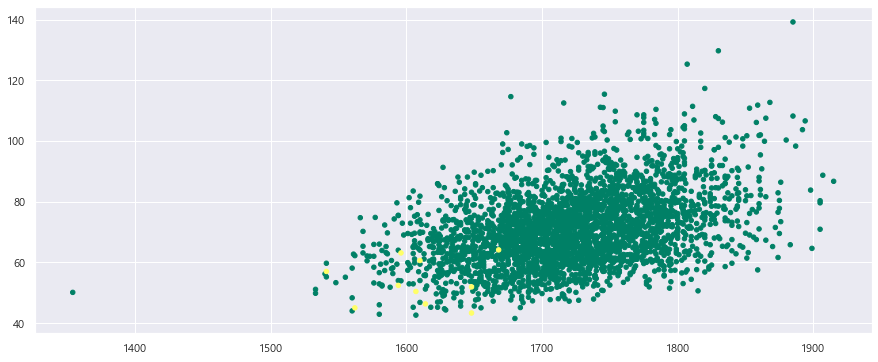

In [76]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='summer')

#### stratify option

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)

In [78]:
# summarize dataset
print(f'Dataset: Class0={(y==0).sum()}, Class1={(y==1).sum()}')
print(f'Train: Class0={(y_train==0).sum()}, Class1={(y_train==1).sum()}')
print(f'Test: Class0={(y_test==0).sum()}, Class1={(y_test==1).sum()}')

Dataset: Class0=3188, Class1=10
Train: Class0=1594, Class1=5
Test: Class0=1594, Class1=5


In [79]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

LogisticRegression()

In [80]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)

target_names = ['Negative(0)', 'Positive(1)']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Negative(0)       1.00      1.00      1.00      1594
 Positive(1)       0.25      0.20      0.22         5

    accuracy                           1.00      1599
   macro avg       0.62      0.60      0.61      1599
weighted avg       1.00      1.00      1.00      1599



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

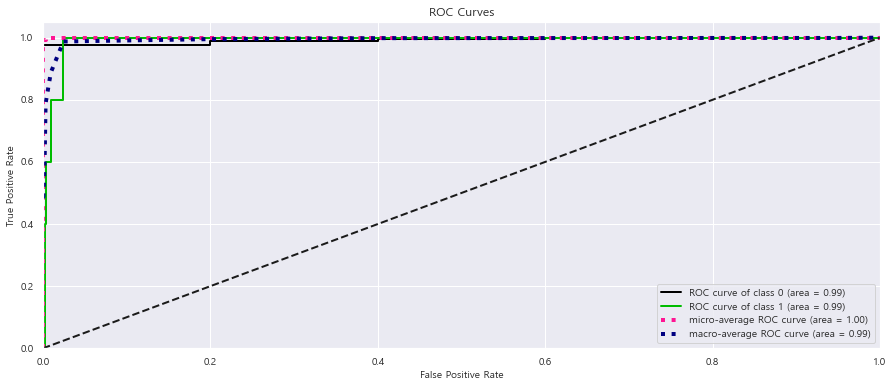

In [81]:
import scikitplot as skplt 
skplt.metrics.plot_roc(y_test, y_probas)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

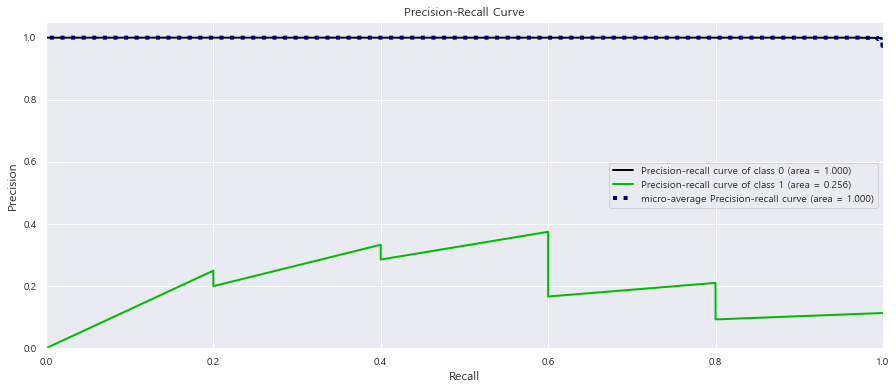

In [82]:
skplt.metrics.plot_precision_recall(y_test, y_probas)

## ROC와 PR curve는 다른 이야기를 하고 있으며 불균형데이터의 예측 성능지표는 AUROC보다는 PR그래프가 우수하다.
### PR 그래프는 소수 범주 자료(양성, 1%)에 집중하는 반면 ROC curve는 음성과 양성 범주 자료를 모두 고려하기 때문이다.

If we use a threshold
of 0.5 and use the logistic regression model to make a prediction for all examples in the test
set, we see that it predicts class 0 or the majority class in all cases. This can be confirmed by
using the fit model to predict crisp class labels that will use the default threshold of 0.5. The
distribution of predicted class labels can then be summarized.

### 사이킷런 내부 모델의 의사결정임계값은 '0.5'로 예측 모델의 결과인 500개는 모두 음성으로 판정한 것을 확인할 수있으며 양성판정 비율은 모두 0.22 이하인 것으로 나타남

In [83]:
np.sort(y_probas[:, 1].round(2))

array([0.  , 0.  , 0.  , ..., 0.68, 0.95, 0.95])

In [84]:
from collections import Counter
# summarize the distribution of class labels
print(Counter(y_pred))

Counter({0: 1595, 1: 4})


# predict_probas에 의한 값중 가장 큰 값이 0.22 --> 0.5를 threshold로 하면 모두 0으로 예측됨

0.9518667345624263

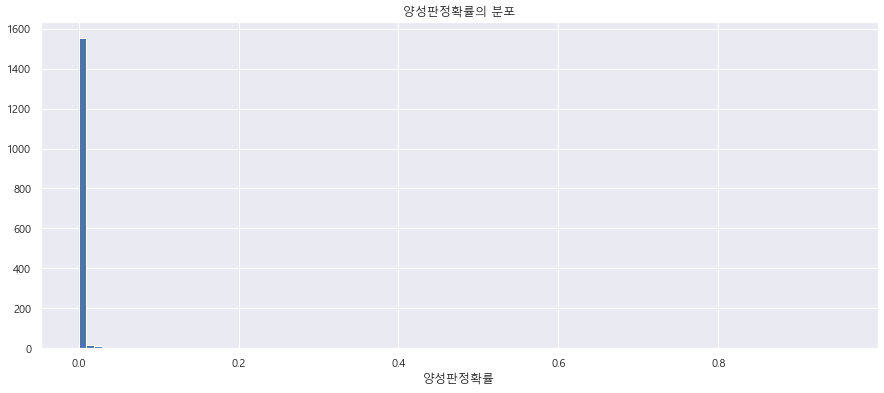

In [85]:
y_scores = y_probas[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포')
plt.xlabel('양성판정확률')
np.max(y_scores)

In [86]:
data = pd.DataFrame(y_scores, columns=['y_predict'])
data.sort_values('y_predict')

,y_predict
807,1.100681e-11
488,9.279878e-11
518,1.098310e-09
666,1.227904e-09
1501,1.437393e-09
...,...
535,3.011158e-01
573,6.318904e-01
873,6.803265e-01
1049,9.501151e-01


## How to Calibrate Probabilities

In [87]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=3)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=3)

In [88]:
calibrated_clf.predict_proba(X_train)[:5, :]

array([[9.98146475e-01, 1.85352523e-03],
       [9.93926261e-01, 6.07373862e-03],
       [9.98174137e-01, 1.82586255e-03],
       [9.99593997e-01, 4.06003347e-04],
       [9.98714076e-01, 1.28592399e-03]])

Text(0.5, 0, '양성판정확률')

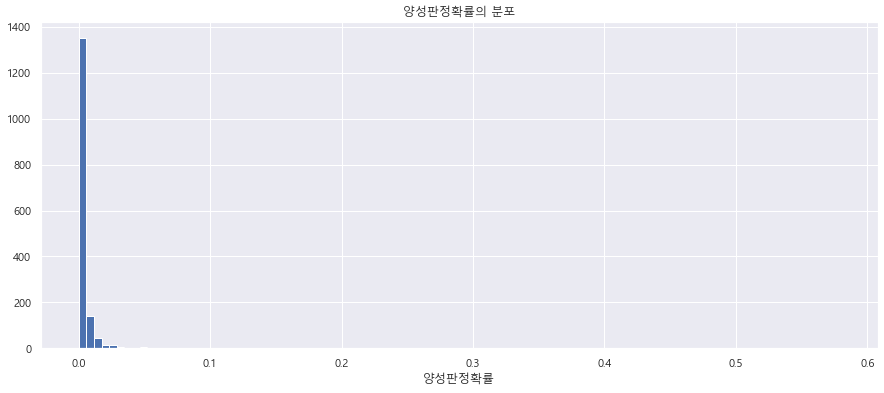

In [89]:
yhat = calibrated_clf.predict_proba(X_test)
model_probs = yhat[:, 1]
pd.DataFrame(model_probs).hist(bins=100)
plt.title('양성판정확률의 분포')
plt.xlabel('양성판정확률')

array([[<AxesSubplot:title={'center':'y_predict'}>,
        <AxesSubplot:title={'center':'y_predict_calibrated'}>]],
      dtype=object)

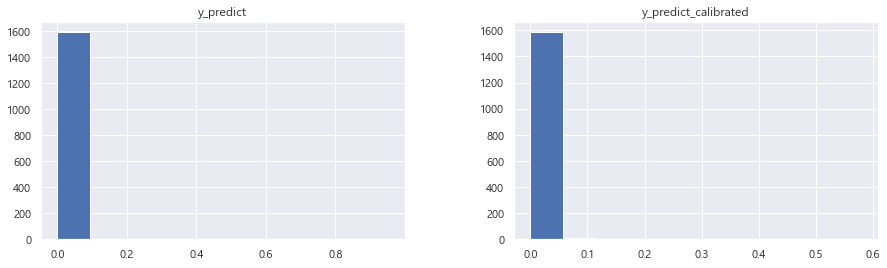

In [90]:
data['y_predict_calibrated'] = yhat[:, 1]
data.hist(figsize=(15,4))

In [91]:
data.head()

,y_predict,y_predict_calibrated
0,0.000165,0.005429
1,0.001856,0.004478
2,0.000034,0.000712
3,0.002882,0.004069
4,0.000006,0.000121


In [92]:
data.reset_index().rename(columns={'index':'idx'})

,idx,y_predict,y_predict_calibrated
0,0,0.000165,0.005429
1,1,0.001856,0.004478
2,2,0.000034,0.000712
3,3,0.002882,0.004069
4,4,0.000006,0.000121
...,...,...,...
1594,1594,0.000007,0.000317
1595,1595,0.000639,0.003406
1596,1596,0.000004,0.000434
1597,1597,0.001648,0.009636


<AxesSubplot:xlabel='index', ylabel='y_predict_calibrated'>

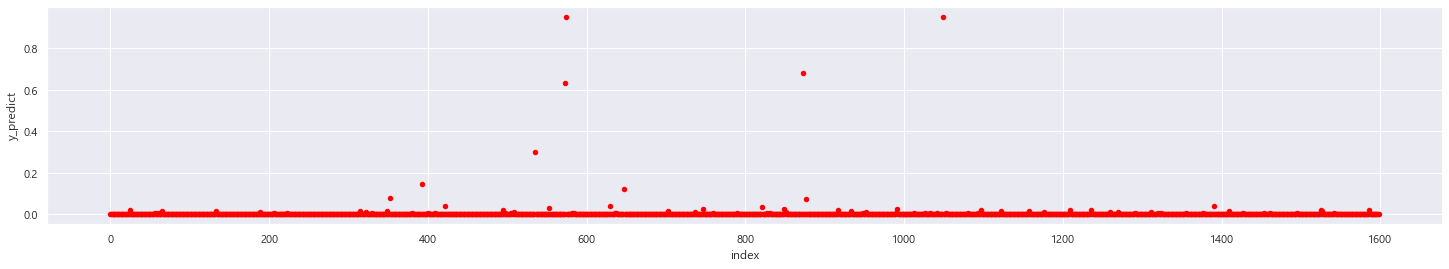

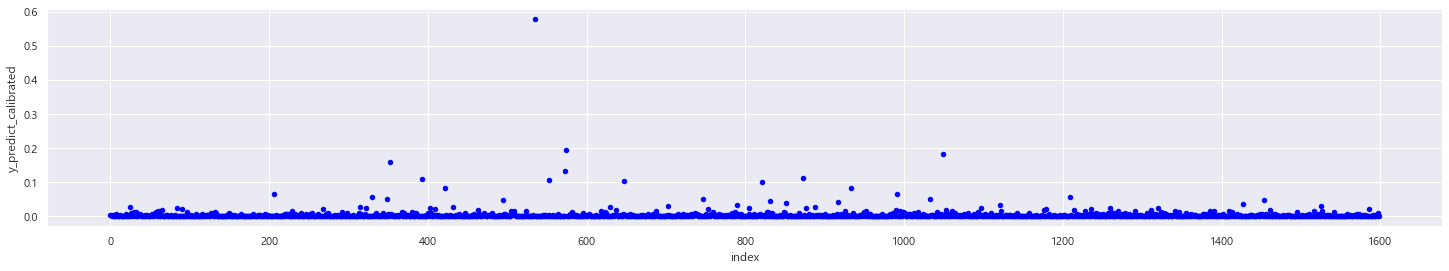

In [93]:
import warnings
warnings.filterwarnings(action='ignore') 
data.reset_index().plot.scatter(x='index', y='y_predict',            c='red', figsize=(25,4))
data.reset_index().plot.scatter(x='index', y='y_predict_calibrated', c='blue', figsize=(25,4))

https://scikit-learn.org/stable/modules/calibration.html#calibration

A histogram plot of the predicted probabilities for class 1 is also created, showing the center of mass (most predicted probabilities) is less than 0.5 and in fact is generally close to zero.